# HR Analytics: Job Change of Data Scientists
**Challenge: Predict who will move to a new job**

In [1]:
# For AWS related
import boto3
import sagemaker

import io
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Loading from S3
Get the file names by connecting to an AWS client (here S3) using boto3. [Refer docs](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/core/session.html#boto3.session.Session.client)

In [2]:
client = boto3.client('s3')
name = 'hr-analytics-2021'

# Listing objects loaded from the bucket
obj_list = client.list_objects(Bucket=name)

filenames = [content['Key'] for content in obj_list['Contents']]
filenames

['aug_test.csv', 'aug_train.csv', 'sample_submission.csv']

In [ ]:
def load_files(file):
    # Get the desired object
    obj = client.get_object(Bucket=name, Key=file)
    
    # This object contains file metadata like its type, modification time, etc.
    # The Body in this contains the streaming data to read
    data_bytes = obj['Body'].read()
    
    # Convert streaming data in bytes to a file in memory 
    data = io.BytesIO(data_bytes)
    df = pd.read_csv(data)
    return df

In [ ]:
aug_test = load_files('aug_test.csv')
aug_train = load_files('aug_train.csv')
sample_submission = load_files('sample_submission.csv')

## Data Pre-Processing

In [6]:
aug_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [21]:
aug_train.describe(include='all')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,19158.000000,19158,19158.000000,14650,19158,18772,18698,16345,19093,13220,13018,18735,19158.000000,19158.000000
unique,NaN,123,NaN,3,2,3,5,6,22,8,6,6,NaN,NaN
top,NaN,city_103,NaN,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,NaN,NaN
freq,NaN,4355,NaN,13221,13792,13817,11598,14492,3286,3083,9817,8040,NaN,NaN
mean,16875.358179,NaN,0.828848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.366896,0.249348
std,9616.292592,NaN,0.123362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.058462,0.432647
min,1.000000,NaN,0.448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,8554.250000,NaN,0.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,0.000000
50%,16982.500000,NaN,0.903000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.000000,0.000000
75%,25169.750000,NaN,0.920000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.000000,0.000000


In [22]:
aug_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [23]:
aug_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [34]:
fill_list = []
for col in aug_train.columns:
    if len(aug_train[aug_train[col].isna()]):
        fill_list.append(col)

fill_list        

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [35]:
# Fill NA with forward fill strategy
def fill(df, fill_list):
    for col in fill_list:
        df[col] = df[col].fillna(method='ffill')
        # In case 1st row is empty
        df[col] = df[col].fillna(method='bfill')
        
    return df

aug_train = fill(aug_train, fill_list)
aug_test = fill(aug_test, fill_list)

def check(df):
    # Assert all column are filled
    for col in fill_list:
        if len(df[df[col].isna()]):
            print(f'{col} has nulls')
            
check(aug_train)            
check(aug_test)            

#### Modifying columns separately

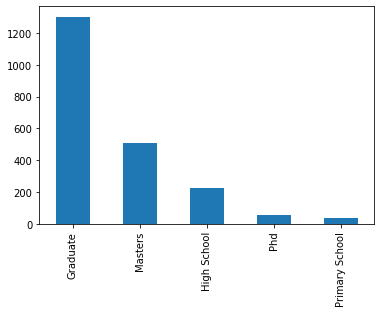

In [40]:
# 1. Education level 
aug_test.education_level.value_counts().plot.bar();

In [42]:
# Replacing school level education
aug_train = aug_train.replace(['Primary School', 'High School'], 'School')
aug_test = aug_test.replace(['Primary School', 'High School'], 'School')

In [45]:
aug_test.major_discipline.unique()

array(['STEM', 'Other', 'Business Degree', 'Arts', 'Humanities',
       'No Major'], dtype=object)

#### Handling the numerical columns

In [49]:
# Replacing the default 
aug_train = aug_train.replace('never', '0')
aug_test = aug_test.replace('never', '0')

In [57]:
def replace_int(df, num_col):
    for col in num_col:
        for i in range(len(df)):
            val = df.loc[i,col]
            val = int(re.match('\d+',val).group(0))
            df.loc[i,col] = val
       
    type_dict = {c:'int32' for c in num_col}
    df = df.astype(type_dict)
    return df

num_col = ['experience', 'company_size', 'last_new_job']

aug_train = replace_int(aug_train, num_col)
aug_test = replace_int(aug_test, num_col)

In [64]:
aug_train.experience#.unique()

0        143
1        143
2        143
3        143
4        143
        ... 
19153    143
19154    143
19155    143
19156    143
19157    143
Name: experience, Length: 19158, dtype: int32

In [63]:
aug_train=aug_train.astype({'experience':'int32'})